# Linear Regression — End-to-End

This notebook contains the end-to-end linear regression pipeline you provided, split into logical Jupyter cells for readability and step-by-step execution. Assumes `retail_store_inventory.csv` is in the same directory as the notebook.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib   # optional: to save model artifacts
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# -------------------------
# Helper functions
# -------------------------
def smape(actual, forecast):
    """Symmetric Mean Absolute Percentage Error (avoids divide-by-zero)."""
    actual = np.array(actual, dtype=float)
    forecast = np.array(forecast, dtype=float)
    denom = (np.abs(actual) + np.abs(forecast))
    mask = denom == 0
    denom[mask] = 1.0
    return 100.0 * np.mean(2.0 * np.abs(forecast - actual) / denom)

def print_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    smape_val = smape(y_true, y_pred)
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"sMAPE: {smape_val:.4f}%")
    print(f"R²:   {r2:.4f}")
    return {'MAE': mae, 'RMSE': rmse, 'sMAPE': smape_val, 'R2': r2}


In [ ]:
# -------------------------
# Load dataset
# -------------------------
file_path = '/content/drive/MyDrive/data/retail_store_inventory.csv'
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path} - put 'retail_store_inventory.csv' in current directory")

df = pd.read_csv(file_path)
print("Loaded dataset shape:", df.shape)
display(df.head())

Loaded dataset shape: (73100, 15)


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


In [ ]:
# -------------------------
# Basic inspection & cleaning
# -------------------------
print("\nData types:")
print(df.dtypes)
print("\nMissing values per column:")
print(df.isnull().sum())

# Simple missing-value strategy: forward/backward fill (adjust as needed)
df = df.fillna(method='ffill').fillna(method='bfill')


Data types:
Date                   object
Store ID               object
Product ID             object
Category               object
Region                 object
Inventory Level         int64
Units Sold              int64
Units Ordered           int64
Demand Forecast       float64
Price                 float64
Discount                int64
Weather Condition      object
Holiday/Promotion       int64
Competitor Pricing    float64
Seasonality            object
dtype: object

Missing values per column:
Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64


/tmp/ipython-input-3082113766.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


In [ ]:
# -------------------------
# Feature engineering (date + simple)
# -------------------------
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    if df['Date'].isnull().any():
        df = df[df['Date'].notnull()].copy()
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['IsWeekend'] = df['DayOfWeek'].isin([5,6]).astype(int)

# Basic numeric sanity: ensure target exists
target_col = 'Units Sold'
if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found. Available columns: {df.columns.tolist()}")

# Drop identifiers that are not predictive (if present)
drop_cols = []
for c in ['Store ID', 'Product ID', 'Date']:
    if c in df.columns:
        drop_cols.append(c)
if drop_cols:
    df = df.drop(columns=drop_cols)

print('\nAfter feature engineering, shape:', df.shape)


After feature engineering, shape: (73100, 18)


In [ ]:
# -------------------------
# Encode categorical variables (one-hot)
# -------------------------
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("\nCategorical columns to encode:", cat_cols)
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)


Categorical columns to encode: ['Category', 'Region', 'Weather Condition', 'Seasonality']


In [ ]:
# -------------------------
# Train/test split
# -------------------------
X = df.drop(columns=[target_col])
y = df[target_col]

# Quick check: if any infinite or NaN values in X, drop those rows
mask_valid = np.isfinite(X.select_dtypes(include=[np.number])).all(axis=1)
if not mask_valid.all():
    X = X[mask_valid].copy()
    y = y[mask_valid].copy()

# Stratify/shuffle: for time-series you might not shuffle. Here we do a random split.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, shuffle=True
)

print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (58480, 26) Test shape: (14620, 26)


In [ ]:
# -------------------------
# Scale features
# -------------------------
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [ ]:
# -------------------------
# Train Linear Regression
# -------------------------
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression()

In [ ]:
# -------------------------
# Predict & Evaluate
# -------------------------
y_pred = lr.predict(X_test_scaled)
print("\nEvaluation on test set:")
metrics = print_metrics(y_test, y_pred)


Evaluation on test set:
MAE:  7.4187
RMSE: 8.6018
sMAPE: 17.6400%
R²:   0.9938


In [ ]:
# -------------------------
# Coefficients (top features by absolute value)
# -------------------------
coef_df = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'coefficient': lr.coef_
})
coef_df['abs_coef'] = coef_df['coefficient'].abs()
coef_df = coef_df.sort_values(by='abs_coef', ascending=False).reset_index(drop=True)
print("\nTop 15 features by absolute coefficient:")
display(coef_df.head(15)[['feature','coefficient']])


Top 15 features by absolute coefficient:


,feature,coefficient
0,Demand Forecast,108.300327
1,Inventory Level,0.509734
2,Region_South,-0.231310
3,Region_West,-0.171740
4,WeekOfYear,-0.165766
5,Month,0.149072
6,Region_North,-0.143871
7,Competitor Pricing,0.132137
8,Category_Groceries,0.123090
9,Category_Electronics,0.100058


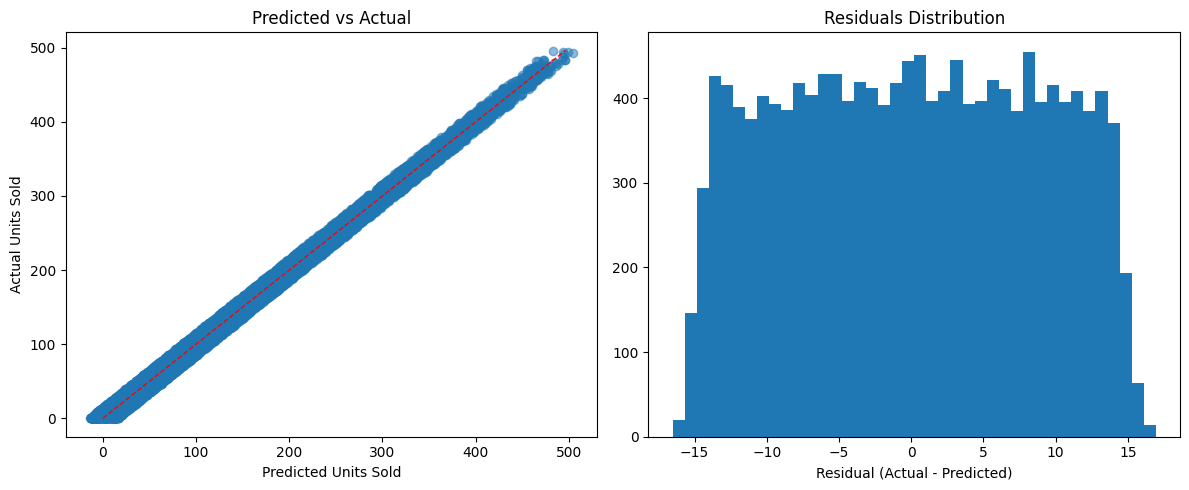

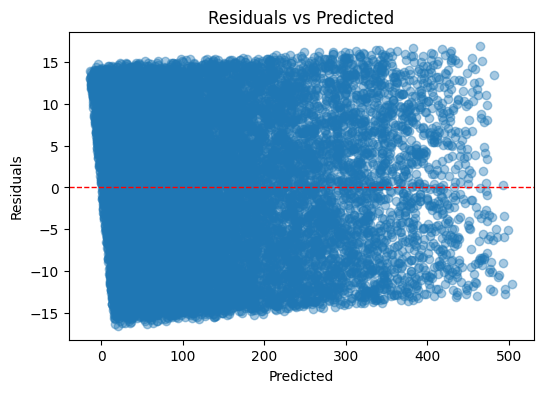

In [ ]:
# -------------------------
# Diagnostic plots
# -------------------------
residuals = y_test - y_pred

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(y_pred, y_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=1)
plt.xlabel('Predicted Units Sold')
plt.ylabel('Actual Units Sold')
plt.title('Predicted vs Actual')

plt.subplot(1,2,2)
plt.hist(residuals, bins=40)
plt.xlabel('Residual (Actual - Predicted)')
plt.title('Residuals Distribution')

plt.tight_layout()
plt.show()

# Residuals vs predicted (to check heteroscedasticity)
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.4)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()

In [ ]:
# -------------------------
# Optional: Save model and scaler
# -------------------------
save_artifacts = True
if save_artifacts:
    joblib.dump(lr, 'linear_regression_model.joblib')
    joblib.dump(scaler, 'scaler.joblib')
    print("\nSaved artifacts: linear_regression_model.joblib and scaler.joblib")


Saved artifacts: linear_regression_model.joblib and scaler.joblib


In [ ]:
# -------------------------
# Next suggestions
# -------------------------
print("\nNext suggestions:")
print("- Add lag/rolling features grouped by store/product to capture temporal dynamics.")
print("- Try regularized linear models (Ridge/Lasso) and tree-based models (RandomForest, XGBoost).")
print("- Use SHAP for interpretability of tree models (or linear coeffs for linear model).")
print("- For a true time-series split, use a chronological train/test split rather than random shuffle.")


Next suggestions:
- Add lag/rolling features grouped by store/product to capture temporal dynamics.
- Try regularized linear models (Ridge/Lasso) and tree-based models (RandomForest, XGBoost).
- Use SHAP for interpretability of tree models (or linear coeffs for linear model).
- For a true time-series split, use a chronological train/test split rather than random shuffle.
